In [1001]:
# Notes for user:
# This notebook will use the dataset COVID-19 and forex to predict the forex spot price of a currency pair.
# What to ask user before using this application:
# What currency pair are you interested in? USD/GBP (This layout means that the base currency is USD)
# The currency the user wants to look at is how much the USD is worth to the GBP.
# Therefore, we look at the death rates in the US and the UK.


# Use some functions from tensorflow_docs
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-yjh7miyb
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-yjh7miyb
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0d41eeb858e80108db8d13ba25867757d7de0fcf9_-cp36-none-any.whl size=124709 sha256=74b38ebe38ef86d8adaa1b183039ba2b1c2da1baa4f7c33dc66906769439816d
  Stored in directory: /tmp/pip-ephem-wheel-cache-zsa84iky/wheels/eb/1b/35/fce87697be00d2fc63e0b4b395b0d9c7e391a10e98d9a0d97f
Successfully built tensorflow-docs


In [1002]:
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [1003]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
print(tf.__version__)

2.2.0


In [1004]:
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

In [1005]:
# Importing covid_dataset using pandas. Droping null values.
covid_dataset_data= pd.read_csv('covid.csv', na_values = "?", comment='\t', skipinitialspace=True)
covid_dataset = covid_dataset_data.copy()
covid_dataset = covid_dataset.dropna()
covid_dataset.head()

,iso_code,continent,location,date,total_cases,new_cases,total_deaths,new_deaths,total_cases_per_million,new_cases_per_million,total_deaths_per_million,new_deaths_per_million,total_tests,new_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,tests_units,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cvd_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy
2164,BGD,Asia,Bangladesh,2020-03-15,3.0,0.0,0.0,0.0,0.018,0.000,0.0,0.0,268.0,27.0,0.002,0.0,20.0,0.0,samples tested,13.89,164689383.0,1265.036,27.5,5.098,3.262,3523.984,14.8,298.003,8.38,1.0,44.7,34.808,0.8,72.59
2166,BGD,Asia,Bangladesh,2020-03-17,5.0,2.0,0.0,0.0,0.030,0.012,0.0,0.0,342.0,49.0,0.002,0.0,28.0,0.0,samples tested,33.33,164689383.0,1265.036,27.5,5.098,3.262,3523.984,14.8,298.003,8.38,1.0,44.7,34.808,0.8,72.59
2167,BGD,Asia,Bangladesh,2020-03-18,8.0,3.0,0.0,0.0,0.049,0.018,0.0,0.0,381.0,39.0,0.002,0.0,31.0,0.0,samples tested,33.33,164689383.0,1265.036,27.5,5.098,3.262,3523.984,14.8,298.003,8.38,1.0,44.7,34.808,0.8,72.59
2168,BGD,Asia,Bangladesh,2020-03-19,10.0,2.0,0.0,0.0,0.061,0.012,0.0,0.0,427.0,46.0,0.003,0.0,34.0,0.0,samples tested,75.93,164689383.0,1265.036,27.5,5.098,3.262,3523.984,14.8,298.003,8.38,1.0,44.7,34.808,0.8,72.59
2169,BGD,Asia,Bangladesh,2020-03-20,10.0,0.0,0.0,0.0,0.061,0.000,0.0,0.0,463.0,36.0,0.003,0.0,36.0,0.0,samples tested,75.93,164689383.0,1265.036,27.5,5.098,3.262,3523.984,14.8,298.003,8.38,1.0,44.7,34.808,0.8,72.59


In [1006]:
# Trying to isolate location/country based on currency in question
# We are looking at pound and sterling therefore need to isolate 'United Kingdom' & 'United States' in location column
# Problem: Informaiton prints up until 'Trinidad and Tobago' for some reason – can print 'Togo'. Therefore cannot print United Kingdom or United States
uk_death_rates = covid_dataset.loc[covid_dataset.location=='Zimbabwe', ['location', 'date', 'total_deaths']]
uk_death_rates.head()

,location,date,total_deaths
27729,Zimbabwe,2020-05-13,4.0
27732,Zimbabwe,2020-05-16,4.0
27733,Zimbabwe,2020-05-17,4.0
27734,Zimbabwe,2020-05-18,4.0
27735,Zimbabwe,2020-05-19,4.0


In [1007]:
uk_death_rates.shape

(37, 3)

In [1008]:
us_death_rates = covid_dataset.loc[covid_dataset.location=='Bangladesh', ['location', 'date', 'total_deaths']]
us_death_rates.head()

,location,date,total_deaths
2164,Bangladesh,2020-03-15,0.0
2166,Bangladesh,2020-03-17,0.0
2167,Bangladesh,2020-03-18,0.0
2168,Bangladesh,2020-03-19,0.0
2169,Bangladesh,2020-03-20,0.0


In [1009]:
us_death_rates.shape

(103, 3)

In [1010]:
forex_dataset_data= pd.read_csv('GBP_USD.csv', na_values = "?", comment='\t', skipinitialspace=True)
forex_dataset = forex_dataset_data.copy()
forex_dataset = forex_dataset_data.dropna()
forex_dataset.tail()


,Date,Price,Open,High,Low,Change %
150,"Dec 06, 2019",1.3137,1.3157,1.3167,1.3100,-0.15%
151,"Dec 05, 2019",1.3157,1.3105,1.3168,1.3102,0.40%
152,"Dec 04, 2019",1.3104,1.2992,1.3121,1.2981,0.85%
153,"Dec 03, 2019",1.2994,1.2938,1.3013,1.2930,0.44%
154,"Dec 02, 2019",1.2937,1.2917,1.2951,1.2895,0.02%


In [1011]:
# Isolate covid_date
import time 
covid_date = covid_dataset['date']
new_covid_dates = [time.strptime(x.replace("-"," "), '%Y %m %d')for x in covid_date]
covid_dataset['date'] = new_covid_dates
covid_dataset.tail()



,iso_code,continent,location,date,total_cases,new_cases,total_deaths,new_deaths,total_cases_per_million,new_cases_per_million,total_deaths_per_million,new_deaths_per_million,total_tests,new_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,tests_units,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cvd_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy
27765,ZWE,Africa,Zimbabwe,"(2020, 6, 18, 0, 0, 0, 3, 170, -1)",401.0,7.0,4.0,0.0,26.980,0.471,0.269,0.000,25815.0,524.0,1.737,0.035,392.0,0.026,tests performed,70.37,14862927.0,42.729,19.6,2.822,1.882,1899.775,21.4,307.846,1.82,1.6,30.7,36.791,1.7,61.49
27766,ZWE,Africa,Zimbabwe,"(2020, 6, 19, 0, 0, 0, 4, 171, -1)",463.0,62.0,4.0,0.0,31.151,4.171,0.269,0.000,26117.0,302.0,1.757,0.020,369.0,0.025,tests performed,70.37,14862927.0,42.729,19.6,2.822,1.882,1899.775,21.4,307.846,1.82,1.6,30.7,36.791,1.7,61.49
27767,ZWE,Africa,Zimbabwe,"(2020, 6, 20, 0, 0, 0, 5, 172, -1)",479.0,16.0,4.0,0.0,32.228,1.077,0.269,0.000,26451.0,334.0,1.780,0.022,349.0,0.023,tests performed,70.37,14862927.0,42.729,19.6,2.822,1.882,1899.775,21.4,307.846,1.82,1.6,30.7,36.791,1.7,61.49
27768,ZWE,Africa,Zimbabwe,"(2020, 6, 21, 0, 0, 0, 6, 173, -1)",486.0,7.0,6.0,2.0,32.699,0.471,0.404,0.135,26857.0,406.0,1.807,0.027,393.0,0.026,tests performed,70.37,14862927.0,42.729,19.6,2.822,1.882,1899.775,21.4,307.846,1.82,1.6,30.7,36.791,1.7,61.49
27769,ZWE,Africa,Zimbabwe,"(2020, 6, 22, 0, 0, 0, 0, 174, -1)",489.0,3.0,6.0,0.0,32.901,0.202,0.404,0.000,27221.0,364.0,1.831,0.024,373.0,0.025,tests performed,70.37,14862927.0,42.729,19.6,2.822,1.882,1899.775,21.4,307.846,1.82,1.6,30.7,36.791,1.7,61.49


In [1012]:
# Isolate forex_date
import time 
forex_date = forex_dataset['Date']
new_forex_dates = [time.strptime(x.replace(',', ""), '%b %d %Y')for x in forex_date]
print(new_forex_dates)
forex_dataset['Date'] = new_forex_dates
forex_dataset.tail()

[time.struct_time(tm_year=2020, tm_mon=7, tm_mday=3, tm_hour=0, tm_min=0, tm_sec=0, tm_wday=4, tm_yday=185, tm_isdst=-1), time.struct_time(tm_year=2020, tm_mon=7, tm_mday=2, tm_hour=0, tm_min=0, tm_sec=0, tm_wday=3, tm_yday=184, tm_isdst=-1), time.struct_time(tm_year=2020, tm_mon=7, tm_mday=1, tm_hour=0, tm_min=0, tm_sec=0, tm_wday=2, tm_yday=183, tm_isdst=-1), time.struct_time(tm_year=2020, tm_mon=6, tm_mday=30, tm_hour=0, tm_min=0, tm_sec=0, tm_wday=1, tm_yday=182, tm_isdst=-1), time.struct_time(tm_year=2020, tm_mon=6, tm_mday=29, tm_hour=0, tm_min=0, tm_sec=0, tm_wday=0, tm_yday=181, tm_isdst=-1), time.struct_time(tm_year=2020, tm_mon=6, tm_mday=26, tm_hour=0, tm_min=0, tm_sec=0, tm_wday=4, tm_yday=178, tm_isdst=-1), time.struct_time(tm_year=2020, tm_mon=6, tm_mday=25, tm_hour=0, tm_min=0, tm_sec=0, tm_wday=3, tm_yday=177, tm_isdst=-1), time.struct_time(tm_year=2020, tm_mon=6, tm_mday=24, tm_hour=0, tm_min=0, tm_sec=0, tm_wday=2, tm_yday=176, tm_isdst=-1), time.struct_time(tm_year=2

,Date,Price,Open,High,Low,Change %
150,"(2019, 12, 6, 0, 0, 0, 4, 340, -1)",1.3137,1.3157,1.3167,1.3100,-0.15%
151,"(2019, 12, 5, 0, 0, 0, 3, 339, -1)",1.3157,1.3105,1.3168,1.3102,0.40%
152,"(2019, 12, 4, 0, 0, 0, 2, 338, -1)",1.3104,1.2992,1.3121,1.2981,0.85%
153,"(2019, 12, 3, 0, 0, 0, 1, 337, -1)",1.2994,1.2938,1.3013,1.2930,0.44%
154,"(2019, 12, 2, 0, 0, 0, 0, 336, -1)",1.2937,1.2917,1.2951,1.2895,0.02%


In [1013]:
# Merging dates from two tables
# Created us_death_rate table
# Problem: United States did not work when == 'United States'
# Shall use Zimbabwe as an example for now and will go back to figure why this is the case 
dataset = pd.merge(left=forex_dataset, left_on='Date',
         right=covid_dataset, right_on='date')
us_death_rates = dataset.loc[dataset.location=='Zimbabwe', ['location', 'date', 'total_deaths','Price']]
us_death_rates.head()


,location,date,total_deaths,Price
94,Zimbabwe,"(2020, 6, 22, 0, 0, 0, 0, 174, -1)",6.0,1.2463
112,Zimbabwe,"(2020, 6, 19, 0, 0, 0, 4, 171, -1)",4.0,1.2358
130,Zimbabwe,"(2020, 6, 18, 0, 0, 0, 3, 170, -1)",4.0,1.2426
148,Zimbabwe,"(2020, 6, 17, 0, 0, 0, 2, 169, -1)",4.0,1.2557
167,Zimbabwe,"(2020, 6, 16, 0, 0, 0, 1, 168, -1)",4.0,1.2577


In [1014]:
# Created uk_death_rate table
# Problem: United Kingdom did not work when == 'United Kingdom'
# Shall use Bangladesh as an example for now and will go back to figure why this is the case 
uk_death_rates = dataset.loc[dataset.location=='Bangladesh', ['location', 'date', 'total_deaths','Price']]
uk_death_rates.sum() # Clean the data – Unsure what this means exactly
uk_death_rates.head()

,location,date,total_deaths,Price
19,Bangladesh,"(2020, 6, 26, 0, 0, 0, 4, 178, -1)",1621.0,1.2335
32,Bangladesh,"(2020, 6, 25, 0, 0, 0, 3, 177, -1)",1582.0,1.2418
46,Bangladesh,"(2020, 6, 24, 0, 0, 0, 2, 176, -1)",1545.0,1.2420
61,Bangladesh,"(2020, 6, 23, 0, 0, 0, 1, 175, -1)",1502.0,1.2520
76,Bangladesh,"(2020, 6, 22, 0, 0, 0, 0, 174, -1)",1464.0,1.2463


In [1015]:
# Looking at US first
# Split the data into train and test
# We will use our test set in the final evaluation of our model
train_dataset = us_death_rates.sample(frac=0.8,random_state=0)
test_dataset = us_death_rates.drop(train_dataset.index)
train_dataset.tail()
test_dataset.tail()


,location,date,total_deaths,Price
94,Zimbabwe,"(2020, 6, 22, 0, 0, 0, 0, 174, -1)",6.0,1.2463
148,Zimbabwe,"(2020, 6, 17, 0, 0, 0, 2, 169, -1)",4.0,1.2557
329,Zimbabwe,"(2020, 6, 4, 0, 0, 0, 3, 156, -1)",4.0,1.2595
391,Zimbabwe,"(2020, 6, 1, 0, 0, 0, 0, 153, -1)",4.0,1.2494
552,Zimbabwe,"(2020, 5, 20, 0, 0, 0, 2, 141, -1)",4.0,1.2241


In [1016]:
# Object means string
us_death_rates.dtypes

location         object
date             object
total_deaths    float64
Price           float64
dtype: object

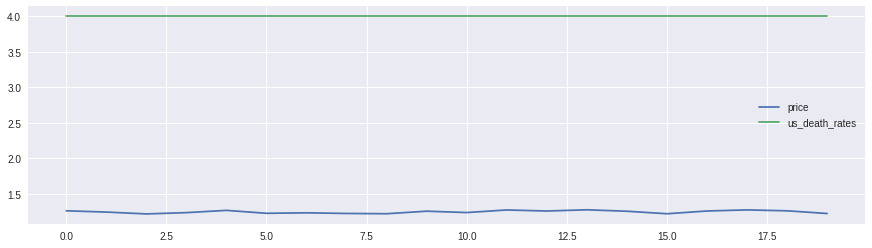

In [1017]:
# Unsure what this graph does at the moment
import matplotlib.pyplot as plt
plt.plot([x for x in range(len(train_dataset["Price"]))], train_dataset["Price"],label="price")
plt.plot([x for x in range(len(train_dataset["total_deaths"]))], train_dataset["total_deaths"], label="us_death_rates")
plt.legend() 
plt.show()


In [1018]:
# View what date looks like
date = us_death_rates['date']
date.head()

94     (2020, 6, 22, 0, 0, 0, 0, 174, -1)
112    (2020, 6, 19, 0, 0, 0, 4, 171, -1)
130    (2020, 6, 18, 0, 0, 0, 3, 170, -1)
148    (2020, 6, 17, 0, 0, 0, 2, 169, -1)
167    (2020, 6, 16, 0, 0, 0, 1, 168, -1)
Name: date, dtype: object

In [1019]:
# Splitting timestamp and isolating the date
dateFormatting = pd.DataFrame({'my_timestamp': pd.date_range('2019-12-31 15:00', periods=len(date))})
dateFormatting['new_date'] = [d.date() for d in dateFormatting['my_timestamp']]
dateFormatting['new_time'] = [d.time() for d in dateFormatting['my_timestamp']]
print(dateFormatting)


          my_timestamp    new_date  new_time
0  2019-12-31 15:00:00  2019-12-31  15:00:00
1  2020-01-01 15:00:00  2020-01-01  15:00:00
2  2020-01-02 15:00:00  2020-01-02  15:00:00
3  2020-01-03 15:00:00  2020-01-03  15:00:00
4  2020-01-04 15:00:00  2020-01-04  15:00:00
5  2020-01-05 15:00:00  2020-01-05  15:00:00
6  2020-01-06 15:00:00  2020-01-06  15:00:00
7  2020-01-07 15:00:00  2020-01-07  15:00:00
8  2020-01-08 15:00:00  2020-01-08  15:00:00
9  2020-01-09 15:00:00  2020-01-09  15:00:00
10 2020-01-10 15:00:00  2020-01-10  15:00:00
11 2020-01-11 15:00:00  2020-01-11  15:00:00
12 2020-01-12 15:00:00  2020-01-12  15:00:00
13 2020-01-13 15:00:00  2020-01-13  15:00:00
14 2020-01-14 15:00:00  2020-01-14  15:00:00
15 2020-01-15 15:00:00  2020-01-15  15:00:00
16 2020-01-16 15:00:00  2020-01-16  15:00:00
17 2020-01-17 15:00:00  2020-01-17  15:00:00
18 2020-01-18 15:00:00  2020-01-18  15:00:00
19 2020-01-19 15:00:00  2020-01-19  15:00:00
20 2020-01-20 15:00:00  2020-01-20  15:00:00
21 2020-01

In [1020]:
# Convert date to list so that we can use the dates to plot on graph
my_xticks = dateFormatting['new_date'].tolist()
print(my_xticks)


[datetime.date(2019, 12, 31), datetime.date(2020, 1, 1), datetime.date(2020, 1, 2), datetime.date(2020, 1, 3), datetime.date(2020, 1, 4), datetime.date(2020, 1, 5), datetime.date(2020, 1, 6), datetime.date(2020, 1, 7), datetime.date(2020, 1, 8), datetime.date(2020, 1, 9), datetime.date(2020, 1, 10), datetime.date(2020, 1, 11), datetime.date(2020, 1, 12), datetime.date(2020, 1, 13), datetime.date(2020, 1, 14), datetime.date(2020, 1, 15), datetime.date(2020, 1, 16), datetime.date(2020, 1, 17), datetime.date(2020, 1, 18), datetime.date(2020, 1, 19), datetime.date(2020, 1, 20), datetime.date(2020, 1, 21), datetime.date(2020, 1, 22), datetime.date(2020, 1, 23), datetime.date(2020, 1, 24)]


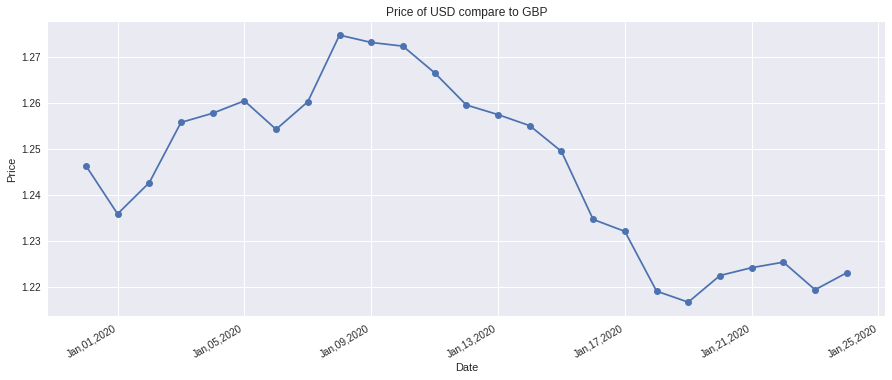

In [1021]:
# Plotted prices and dates
# Notice how the dates start and end

from datetime import datetime, timedelta
from matplotlib import pyplot as plt
from matplotlib import dates as mpl_dates
plt.style.use('seaborn')
from matplotlib import rcParams
rcParams['figure.figsize'] = 15,6

dates = np.array(dateFormatting['new_date'])
price = np.array(us_death_rates['Price'])
plt.plot_date(dates,price, linestyle ='solid')
plt.gcf().autofmt_xdate()
date_format = mpl_dates.DateFormatter('%b,%d,%Y')
plt.title('Price of USD compare to GBP')
plt.xlabel('Date')
plt.ylabel('Price')
plt.gca().xaxis.set_major_formatter(date_format)

In [1022]:
# Adds the accumulative deaths every day of a country
total_us_deaths = uk_death_rates['total_deaths']
total = total_us_deaths.tolist()
day2 = total[0]+total[1]
day3 = day2 + total[3]
day4 = day3 + total[4]
day5 = day4 + total[5]
# ..
accumulative_daily_total = [total[0], day2, day3, day4, day5]
print(accumulative_daily_total)


[1621.0, 3203.0, 4705.0, 6169.0, 7512.0]


['2019,12,31' '2020,01,01' '2020,01,31' '2020,02,31' '2020,03,31']
['1621.0' '3203.0' '4705.0' '6169.0' '7512.0']


Text(0, 0.5, 'Total Deaths')

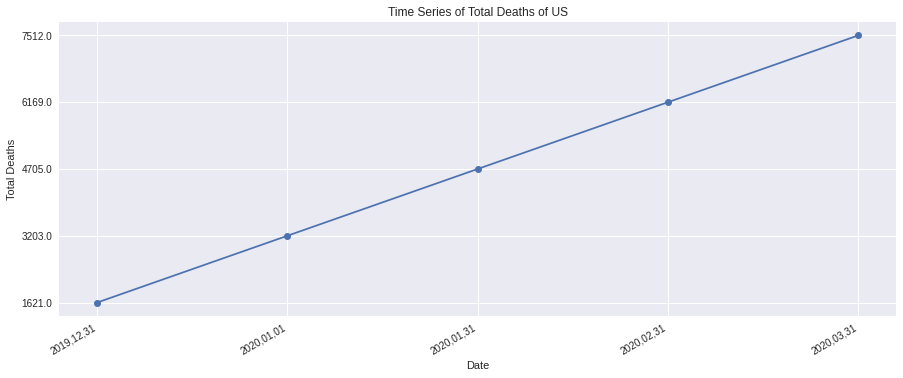

In [1045]:
# Plots the accumulative daily death rates of a country
dates = np.array(['2019,12,31','2020,01,01','2020,01,31','2020,02,31', '2020,03,31']) 
print(dates)
price = np.array(['1621.0', '3203.0', '4705.0', '6169.0', '7512.0'])
print(price)
plt.plot_date(dates,price, linestyle ='solid')
plt.gcf().autofmt_xdate()
date_format = mpl_dates.DateFormatter('%b,%d,%Y')
plt.title('Time Series of Total Deaths of US')
plt.xlabel('Date')
plt.ylabel('Total Deaths')


In [1024]:
# Overall statistics
# Transpose: Row to collumn
# Calculated automatically mean and std
train_stats = train_dataset.describe()
train_stats.pop("Price")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
total_deaths,20.0,4.0,0.0,4.0,4.0,4.0,4.0,4.0


In [1025]:
train_labels = train_dataset.pop('Price')
test_labels = test_dataset.pop('Price')

In [1026]:
# It is good practice to normalize features that use different scales and ranges. 
# Although the model might converge without feature normalization, 
# it makes training more difficult, and it makes the resulting model dependent 
# on the choice of units used in the input. 

# Note: Although we intentionally generate these statistics from only the training dataset, 
# these statistics will also be used to normalize the test dataset. 
# We need to do that to project the test dataset into the same distribution that the model 
# has been trained on.
# for each feature we are finding the mean giving a value between 0 and 1 (around)
# normalising with respect to the price
def norm(x, stats):
  mean_diff = pd.DataFrame( stats['mean'].to_frame().transpose().values, columns=x.columns )
  std_diff  = pd.DataFrame( x.values / stats['std'].to_frame().transpose().values, columns=x.columns )
  return std_diff

columns_to_remove = set( list( train_dataset.columns ) ) - set( 
    list( train_stats['mean'].to_frame().transpose().columns ) )
for col in columns_to_remove : 
  train_dataset.pop( col ) 
  test_dataset.pop( col ) 
normed_train_data = norm(train_dataset, train_stats)
normed_test_data = norm(test_dataset, train_stats)

print(normed_test_data)


   total_deaths
0           inf
1           inf
2           inf
3           inf
4           inf


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in true_divide
  


In [1027]:
# Building a model
# Let's build our model. Here, we'll use a Sequential model with 
# two densely connected hidden layers, and an output layer that 
# returns a single, continuous value. The model building steps are 
# wrapped in a function, build_model, since we'll create a 
# second model, later on.

def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])
# learning rate
  optimizer = tf.keras.optimizers.RMSprop(0.001)
  # WHAT IS THIS OPTIMIZER: https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/RMSprop

# I will try to use the MSE- Mean Square Error and Mean Average error to minimise my losss
# 
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  # note: you are using the mae and mse, if you wanted to use a different optimizer you could use adam
  return model

In [1028]:
model = build_model()

In [1029]:
# Inspect the model
model.summary()

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_90 (Dense)             (None, 64)                128       
_________________________________________________________________
dense_91 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_92 (Dense)             (None, 1)                 65        
Total params: 4,353
Trainable params: 4,353
Non-trainable params: 0
_________________________________________________________________


In [1030]:
# Take a batch of 10 examples from the training data and call model to predict on it.
# Does it produce a result of expected shape and type?
# Question: How do we know the shape?
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]], dtype=float32)

In [1031]:
# Train the model:
# Train the model for 1000 epochs, 
# and record the training and validation accuracy 
# in the `history` object.
# Mean Square Error: Measures every square error of our machine learning predictions
# Verbose = 0 will show you how you want to see the training process
# Verbosity in keyword arguments usually means showing more 'wordy' information 
# for the task. In this case, for machine learning, by setting verbose to a 
# higher number ( 2 vs 1 ), you may see more information about the tree building process
# validation_split is a parameter that gets passed in. It's a number that determines how 
# your data should be partitioned into training and validation sets. For example 
# if validation_split = 0.2 then 20% of your data will be used in the validation set 
# and 80% of your data will be used in the test set

# Interesting notes: Since our MSE is close to 0 at 0.0015 we can say that our model is
# really good

# Meaning of this tabel:
# val_loss is the value of cost function for your cross-validation data and loss 
# is the value of cost function for your training data.

# val_loss: 0.0007 means that it is overfitting
EPOCHS = 1000

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[tfdocs.modeling.EpochDots()])


Epoch: 0, loss:1.5455,  mae:1.2430,  mse:1.5455,  val_loss:1.5633,  val_mae:1.2502,  val_mse:1.5633,  
....................................................................................................
Epoch: 100, loss:1.2877,  mae:1.1346,  mse:1.2877,  val_loss:1.3089,  val_mae:1.1439,  val_mse:1.3089,  
....................................................................................................
Epoch: 200, loss:1.0725,  mae:1.0354,  mse:1.0725,  val_loss:1.0918,  val_mae:1.0447,  val_mse:1.0918,  
....................................................................................................
Epoch: 300, loss:0.8771,  mae:0.9363,  mse:0.8771,  val_loss:0.8946,  val_mae:0.9456,  val_mse:0.8946,  
....................................................................................................
Epoch: 400, loss:0.7015,  mae:0.8373,  mse:0.7015,  val_loss:0.7171,  val_mae:0.8466,  val_mse:0.7171,  
........................................................................

In [1032]:
# Predicted output that we have
# Tensorfow puts everything in tensors
# Values are high due to normalisation
# What im trying to predict | What its giv
prediction = model.predict(test_dataset)
print(prediction)


[[0.99488884]
 [0.99488884]
 [0.99488884]
 [0.99488884]
 [0.99488884]]


In [1033]:
# What i should be predicting 
test_dataset.tail()
testDataList = test_labels.tolist()
# first number is index
# :middle: how many steps we want to take between each value
# end index. everything up until last 5 elements
print(testDataList[len(testDataList)-5::])




[1.2463, 1.2557, 1.2595, 1.2494, 1.2241]


In [1034]:
# take away one from the other
# lines up at index they are
# extract as prediction and actual
# then find the difference 
# take 0th number of that list
# how far off we are off from our output
# note: v different from what forex should look like
for pred, actual in zip(prediction, testDataList):
  difference = pred.tolist()[0] - actual
  print(difference)

-0.2514111578941345
-0.26081115789413456
-0.2646111578941346
-0.2545111578941346
-0.2292111578941345


In [1035]:
# example of what zip does
l = [1,2,3,4]
s = [2,3,4,5]
print(list(zip(l,s)))

[(1, 2), (2, 3), (3, 4), (4, 5)]


In [1036]:
# Visualize the model's training progress using the stats stored in the history object.
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,0.064375,0.252984,0.064375,0.069168,0.262324,0.069168,995
996,0.063887,0.252018,0.063887,0.068662,0.261358,0.068662,996
997,0.063401,0.251052,0.063401,0.068158,0.260393,0.068158,997
998,0.062917,0.250086,0.062917,0.067656,0.259427,0.067656,998
999,0.062435,0.249121,0.062435,0.067156,0.258461,0.067156,999


In [1037]:
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)

Text(0, 0.5, 'MAE [MPG]')

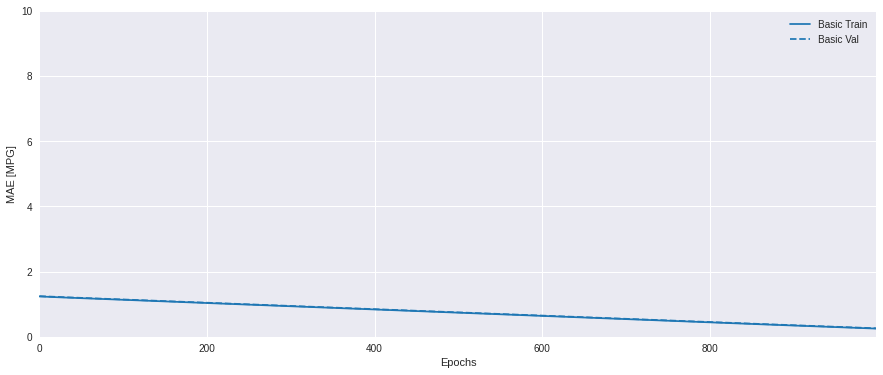

In [1038]:
plotter.plot({'Basic': history}, metric = "mae")
plt.ylim([0, 10])
plt.ylabel('MAE [MPG]')

Text(0, 0.5, 'MSE [MPG^2]')

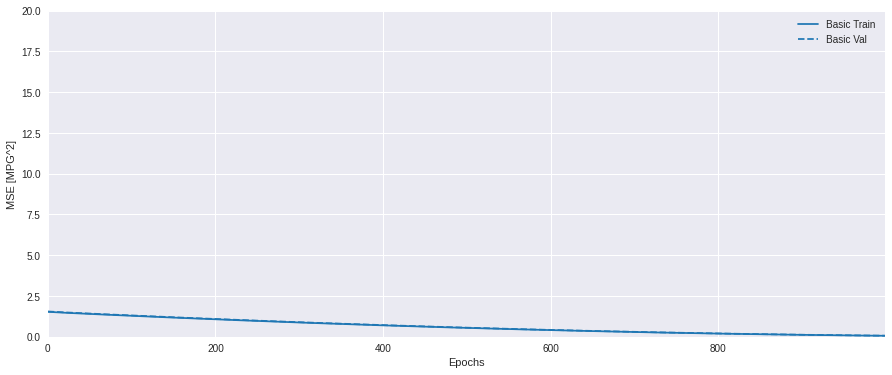

In [1039]:
plotter.plot({'Basic': history}, metric = "mse")
plt.ylim([0, 20])
plt.ylabel('MSE [MPG^2]')

In [1040]:
# This graph shows little improvement, or even degradation in the validation 
# error after about 100 epochs. Let's update the model.fit call to automatically 
# stop training when the validation score doesn't improve. We'll use an 
# EarlyStopping callback that tests a training condition for every epoch. 
# If a set amount of epochs elapses without showing improvement, then 
# automatically stop the training.
model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

early_history = model.fit(normed_train_data, train_labels, 
                    epochs=EPOCHS, validation_split = 0.2, verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:1.5455,  mae:1.2430,  mse:1.5455,  val_loss:1.5633,  val_mae:1.2502,  val_mse:1.5633,  
....................................................................................................
Epoch: 100, loss:1.2877,  mae:1.1346,  mse:1.2877,  val_loss:1.3089,  val_mae:1.1439,  val_mse:1.3089,  
....................................................................................................
Epoch: 200, loss:1.0725,  mae:1.0354,  mse:1.0725,  val_loss:1.0918,  val_mae:1.0447,  val_mse:1.0918,  
....................................................................................................
Epoch: 300, loss:0.8771,  mae:0.9363,  mse:0.8771,  val_loss:0.8946,  val_mae:0.9456,  val_mse:0.8946,  
....................................................................................................
Epoch: 400, loss:0.7015,  mae:0.8373,  mse:0.7015,  val_loss:0.7171,  val_mae:0.8466,  val_mse:0.7171,  
........................................................................

Text(0, 0.5, 'MAE [MPG]')

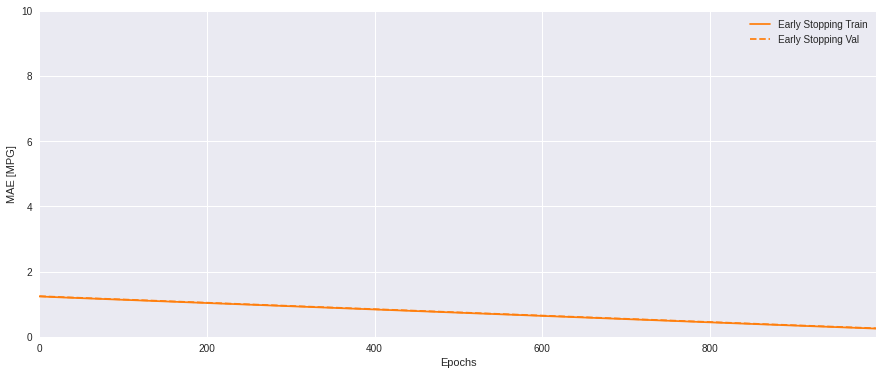

In [1041]:
#
plotter.plot({'Early Stopping': early_history}, metric = "mae")
plt.ylim([0, 10])
plt.ylabel('MAE [MPG]')

In [1042]:
#
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))

1/1 - 0s - loss: 0.0637 - mae: 0.2521 - mse: 0.0637
Testing set Mean Abs Error:  0.25 MPG


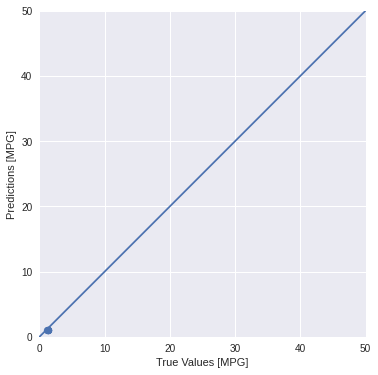

In [1043]:
# Make predictions
test_predictions = model.predict(normed_test_data).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

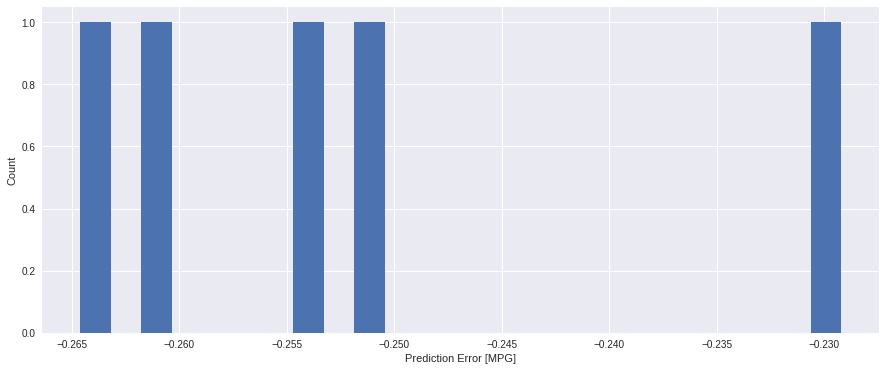

In [1044]:
#
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")